In [1]:
from air_quality_preprocessor_forecasting import AirQualityPreprocessor
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Solicitud_Historica/Historico_pm25_filtered.csv', sep=';')

h = 6  # 6-hour ahead

# Rename the first column to 'Fecha_Hora'
df.rename(columns={df.columns[0]: 'Fecha_Hora'}, inplace=True)

# Convert 'Fecha_Hora' to datetime
df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'], format='%d/%m/%y %H:%M')
# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     'nox', 'calidad_nox',
#     'vviento_ssr', 'calidad_vviento_ssr',
#     'no2', 'calidad_no2',
#     'no', 'calidad_no',
#     'haire10_ssr', 'calidad_haire10_ssr'
#     ]]

# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     'nox', 'calidad_nox',
#     'no2', 'calidad_no2',
#     'no', 'calidad_no',
#     ]]

# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     ]]

In [3]:
df.head()

,Fecha_Hora,BAR-TORR,GIR-SOSN,GIR-EPM,COP-CVID,BEL-FEVE,MED-ARAN,MED-PBLQ,MED-SCRI,MED-FISC,...,ITA-CJUS,MED-LAYE,ITA-CONC,ENV-HOSP,EST-HOSP,SUR-TRAF,SAB-RAME,EST-TABL,CAL-LASA,CAL-JOAR
0,2019-01-01 00:00:00,93.6646,34.0,NaN,NaN,188.8740,198.4560,NaN,108.4140,NaN,...,171.0,17.0,79.0,44.5809,28.0,101.0,62.7140,NaN,65.0,NaN
1,2019-01-01 01:00:00,50.3542,54.0,NaN,NaN,110.1980,134.0200,NaN,70.1561,NaN,...,198.0,22.0,74.0,44.5023,19.0,98.0,44.5194,NaN,57.0,NaN
2,2019-01-01 02:00:00,35.0655,49.0,NaN,NaN,94.8215,83.9968,NaN,44.2872,NaN,...,160.0,11.0,56.0,44.4149,27.0,73.0,45.7275,NaN,65.0,NaN
3,2019-01-01 03:00:00,29.1859,38.0,NaN,NaN,73.6579,59.0683,NaN,41.7584,NaN,...,155.0,22.0,37.0,41.9547,31.0,78.0,58.8523,NaN,35.0,31.6231
4,2019-01-01 04:00:00,27.9737,29.0,NaN,NaN,44.3655,43.6580,NaN,25.7170,NaN,...,115.0,21.0,43.0,35.9086,22.0,83.0,85.0434,NaN,33.0,29.0643


In [4]:
# # Make sure timestamp is datetime
# df["Fecha_Hora"] = pd.to_datetime(df["Fecha_Hora"])

train_start = "2019-01-01"
train_end   = "2021-12-31"

test_start  = "2022-01-01"
test_end    = "2023-12-31"

val_start   = "2024-01-01"
val_end     = "2024-12-31"

mask_train = (df["Fecha_Hora"] >= train_start) & (df["Fecha_Hora"] <= train_end)
mask_test  = (df["Fecha_Hora"] >= test_start)  & (df["Fecha_Hora"] <= test_end)
mask_val   = (df["Fecha_Hora"] >= val_start)   & (df["Fecha_Hora"] <= val_end)

df_train = df.loc[mask_train].copy()
df_test  = df.loc[mask_test].copy()
df_val   = df.loc[mask_val].copy()

## BAR-TORR

In [5]:
preproc = AirQualityPreprocessor(
    target_col="BAR-TORR",      # or any other station column
    quality_col=None,           # <-- no quality column in this dataset
    datetime_col="Fecha_Hora",  # the time column in your file
    freq='1H',                  # or "1H" if you want to enforce hourly frequency
    max_lag=48,                 # pm25_lag1..24 and lags for other numeric vars
    lag_other_cols=None,        # None = lag all numeric columns except target
    missing_col_threshold=0.5, # or e.g. 0.5 to drop very sparse columns
)


# VERY IMPORTANT: fit ONLY on training data (2019–2021)
preproc.fit(df_train)

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

AirQualityPreprocessor(datetime_col='Fecha_Hora', freq='1H', max_lag=48,
                       missing_col_threshold=0.5, target_col='BAR-TORR')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fecha_Hora  52608 non-null  datetime64[ns]
 1   BAR-TORR    49250 non-null  float64       
 2   GIR-SOSN    16804 non-null  float64       
 3   GIR-EPM     34004 non-null  float64       
 4   COP-CVID    50965 non-null  float64       
 5   BEL-FEVE    50181 non-null  float64       
 6   MED-ARAN    50655 non-null  float64       
 7   MED-PBLQ    22670 non-null  float64       
 8   MED-SCRI    50304 non-null  float64       
 9   MED-FISC    40065 non-null  float64       
 10  MED-UNNV    9810 non-null   float64       
 11  MED-VILL    50039 non-null  float64       
 12  CEN-TRAF    49896 non-null  float64       
 13  MED-BEME    50916 non-null  float64       
 14  MED-SELE    47933 non-null  float64       
 15  MED-PROV    10122 non-null  float64       
 16  MED-ALTA    50015 non-

In [7]:
# Train
X_train, y_train, mask_train_valid, idx_train = preproc.transform(df_train)
# X_train = X_train[mask_train_valid]
# y_train = y_train[mask_train_valid]

# Test (2022–2023)
X_test, y_test, mask_test_valid, idx_test = preproc.transform(df_test)
# X_test_valid = X_test[mask_test_valid]
# y_test_valid = y_test[mask_test_valid]

# Validation (2024)
X_val, y_val, mask_val_valid, idx_val = preproc.transform(df_val)
# X_val_valid = X_val[mask_val_valid]
# y_val_valid = y_val[mask_val_valid]

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [8]:
# Base feature matrices as DataFrames
X_train_full = X_train[preproc.feature_cols_]
X_test_full  = X_test[preproc.feature_cols_]
X_val_full   = X_val[preproc.feature_cols_]

y_train_full = y_train
y_test_full  = y_test
y_val_full   = y_val

In [9]:
# --- build 6-hour-ahead targets ---

# Training: X at time t, y at time t+6
X_train_h = X_train_full.iloc[:-h]        # drop last h rows (no future target)
y_train_h = y_train_full[h:]             # drop first h rows

# keep only rows where the 6h-ahead target is valid (not NaN)
mask_train_h = ~np.isnan(y_train_h)
X_train_h = X_train_h.loc[mask_train_h]
y_train_h = y_train_h[mask_train_h]

# Test: same logic
X_test_h = X_test_full.iloc[:-h]
y_test_h = y_test_full[h:]

mask_test_h = ~np.isnan(y_test_h)
X_test_h = X_test_h.loc[mask_test_h]
y_test_h = y_test_h[mask_test_h]

# Validation: same logic
X_val_h = X_val_full.iloc[:-h]
y_val_h = y_val_full[h:]

mask_val_h = ~np.isnan(y_val_h)
X_val_h = X_val_h.loc[mask_val_h]
y_val_h = y_val_h[mask_val_h]

In [10]:
# # use only rows with valid target for supervised training
# X_train_df = X_train.loc[mask_train_valid, preproc.feature_cols_]
# y_train_valid = y_train[mask_train_valid]

# X_test_df  = X_test.loc[mask_test_valid, preproc.feature_cols_]
# y_test_valid = y_test[mask_test_valid]

# X_val_df   = X_val.loc[mask_val_valid, preproc.feature_cols_]
# y_val_valid = y_val[mask_val_valid]

In [11]:
feature_names_transformed = X_train.columns.tolist()
print("Transformed feature names:")
for name in feature_names_transformed:
    print(name)

Transformed feature names:
BAR-TORR
GIR-SOSN
COP-CVID
BEL-FEVE
MED-ARAN
MED-SCRI
MED-FISC
MED-VILL
CEN-TRAF
MED-BEME
MED-SELE
MED-ALTA
MED-TESO
ITA-CJUS
MED-LAYE
ITA-CONC
ENV-HOSP
EST-HOSP
SUR-TRAF
SAB-RAME
CAL-LASA
CAL-JOAR
hour
dayofweek
month
dayofyear
hour_sin
hour_cos
doy_sin
doy_cos
BAR-TORR_lag1
BAR-TORR_lag2
BAR-TORR_lag3
BAR-TORR_lag4
BAR-TORR_lag5
BAR-TORR_lag6
BAR-TORR_lag21
BAR-TORR_lag22
BAR-TORR_lag23
BAR-TORR_lag24
BAR-TORR_lag47
BAR-TORR_lag48
GIR-SOSN_lag1
GIR-SOSN_lag2
GIR-SOSN_lag3
GIR-SOSN_lag4
GIR-SOSN_lag5
GIR-SOSN_lag6
GIR-SOSN_lag21
GIR-SOSN_lag22
GIR-SOSN_lag23
GIR-SOSN_lag24
GIR-SOSN_lag47
GIR-SOSN_lag48
COP-CVID_lag1
COP-CVID_lag2
COP-CVID_lag3
COP-CVID_lag4
COP-CVID_lag5
COP-CVID_lag6
COP-CVID_lag21
COP-CVID_lag22
COP-CVID_lag23
COP-CVID_lag24
COP-CVID_lag47
COP-CVID_lag48
BEL-FEVE_lag1
BEL-FEVE_lag2
BEL-FEVE_lag3
BEL-FEVE_lag4
BEL-FEVE_lag5
BEL-FEVE_lag6
BEL-FEVE_lag21
BEL-FEVE_lag22
BEL-FEVE_lag23
BEL-FEVE_lag24
BEL-FEVE_lag47
BEL-FEVE_lag48
MED-ARAN_lag1


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_cols = preproc.numeric_cols_
categorical_cols = preproc.categorical_cols_

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # RF-specific choice
    ("scaler", StandardScaler())                    # scaling optional for RF
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

col_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


# Train on 2019–2021
rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)

rf_pipeline = Pipeline([
    ("cols", col_transformer),
    ("rf", rf)
])

rf_pipeline.fit(X_train_h, y_train_h)

# Evaluate on 2022–2023
y_test_pred = rf_pipeline.predict(X_test_h)
rmse_test = root_mean_squared_error(y_test_h, y_test_pred)
# Evaluate on 2024
y_val_pred = rf_pipeline.predict(X_val_h)
rmse_val = root_mean_squared_error(y_val_h, y_val_pred)
print("RMSE test (2022–2023):", rmse_test)
print("RMSE val  (2024):", rmse_val)

# Evaluate R2
r2_test = r2_score(y_test_h, y_test_pred)
r2_val = r2_score(y_val_h, y_val_pred)
print("R2 test (2022–2023):", r2_test)
print("R2 val  (2024):", r2_val)

RMSE test (2022–2023): 5.561810423415944
RMSE val  (2024): 6.50516903402788
R2 test (2022–2023): 0.43626626546551106
R2 val  (2024): 0.5457645879296722


In [13]:
X_train_h

,GIR-SOSN,COP-CVID,BEL-FEVE,MED-ARAN,MED-SCRI,MED-FISC,MED-VILL,CEN-TRAF,MED-BEME,MED-SELE,...,CAL-JOAR_lag3,CAL-JOAR_lag4,CAL-JOAR_lag5,CAL-JOAR_lag6,CAL-JOAR_lag21,CAL-JOAR_lag22,CAL-JOAR_lag23,CAL-JOAR_lag24,CAL-JOAR_lag47,CAL-JOAR_lag48
Fecha_Hora,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,34.0,NaN,188.87400,198.45600,108.41400,NaN,57.87900,115.0,67.11790,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,54.0,NaN,110.19800,134.02000,70.15610,NaN,49.15900,79.0,58.68780,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,49.0,NaN,94.82150,83.99680,44.28720,NaN,59.90130,59.0,50.22860,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,38.0,NaN,73.65790,59.06830,41.75840,NaN,74.11800,58.0,53.70660,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,29.0,NaN,44.36550,43.65800,25.71700,NaN,58.45760,63.0,39.32970,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 14:00:00,NaN,7.22548,2.42692,14.69970,9.00558,22.0,NaN,26.0,8.79977,0.50000,...,22.1653,21.9774,33.8712,39.7699,24.0806,36.1647,19.2514,24.1674,11.04040,13.52670
2021-12-30 15:00:00,NaN,4.79095,9.67550,14.55450,10.19920,25.0,8.59919,18.0,13.74070,5.46964,...,19.6984,22.1653,21.9774,33.8712,39.6186,24.0806,36.1647,19.2514,17.05880,11.04040
2021-12-30 16:00:00,NaN,9.51291,4.79856,7.22281,12.58030,20.0,7.29970,28.0,9.81840,1.35940,...,19.6420,19.6984,22.1653,21.9774,17.9883,39.6186,24.0806,36.1647,12.10010,17.05880


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
feature_names = preproc.column_transformer_.get_feature_names_out()

# sort
indices = np.argsort(importances)[::-1]

# how many features to show
n_top = 20
top_idx = indices[:n_top]

plt.figure(figsize=(8, 6))
plt.barh(range(n_top), importances[top_idx][::-1])
plt.yticks(range(n_top), [feature_names[i] for i in top_idx][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest feature importances (transformed features)")
plt.tight_layout()
plt.show()

AttributeError: 'AirQualityPreprocessor' object has no attribute 'column_transformer_'

In [36]:
top_idx

array([ 35,   2,   4,  36,   0,   3,  57,  31,  37,  56,  14,  58,  11,
       275, 611, 179,  10,  81,  82,  55])

In [25]:
# Create an importances dataframe

importances_df=pd.DataFrame(importances, index=feature_names, columns=['Importancia'])

In [26]:
important_features=importances_df.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

In [27]:
importances_df.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

['num__BAR-TORR_lag1',
 'num__COP-CVID',
 'num__MED-ARAN',
 'num__BAR-TORR_lag2',
 'num__GIR-SOSN',
 'num__BEL-FEVE',
 'num__BAR-TORR_lag23',
 'num__hour_sin',
 'num__BAR-TORR_lag3',
 'num__BAR-TORR_lag22',
 'num__MED-ALTA',
 'num__BAR-TORR_lag24',
 'num__MED-BEME',
 'num__MED-ARAN_lag1',
 'num__MED-BEME_lag1',
 'num__COP-CVID_lag1',
 'num__CEN-TRAF',
 'num__BAR-TORR_lag47',
 'num__BAR-TORR_lag48',
 'num__BAR-TORR_lag21']

In [28]:
important_features_list = [feat.split('__')[-1] for feat in important_features]

In [29]:
important_features_list

['BAR-TORR_lag1',
 'COP-CVID',
 'MED-ARAN',
 'BAR-TORR_lag2',
 'GIR-SOSN',
 'BEL-FEVE',
 'BAR-TORR_lag23',
 'hour_sin',
 'BAR-TORR_lag3',
 'BAR-TORR_lag22',
 'MED-ALTA',
 'BAR-TORR_lag24',
 'MED-BEME',
 'MED-ARAN_lag1',
 'MED-BEME_lag1',
 'COP-CVID_lag1',
 'CEN-TRAF',
 'BAR-TORR_lag47',
 'BAR-TORR_lag48',
 'BAR-TORR_lag21']

In [47]:
X_train_small = X_train[:, top_idx[:15]]
X_test_small  = X_test_valid[:,  top_idx[:15]]
X_val_small   = X_val_valid[:,   top_idx[:15]]

In [48]:
rf_small = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_small.fit(X_train_small, y_train)

y_test_pred = rf_small.predict(X_test_small)
y_val_pred  = rf_small.predict(X_val_small)

print("Test R2 (small model):", r2_score(y_test_valid, y_test_pred))
print("Val  R2 (small model):", r2_score(y_val_valid,  y_val_pred))

print("Test RMSE (small model):",
      root_mean_squared_error(y_test_valid, y_test_pred))
print("Val  RMSE (small model):",
      root_mean_squared_error(y_val_valid,  y_val_pred))

Test R2 (small model): 0.6528046423991731
Val  R2 (small model): 0.755566766595413
Test RMSE (small model): 4.367744740820454
Val  RMSE (small model): 4.788165709819629


## COP-CVID

In [51]:
preproc_cop_cvid = AirQualityPreprocessor(
    target_col="COP-CVID",      # or any other station column
    quality_col=None,           # <-- no quality column in this dataset
    datetime_col="Fecha_Hora",  # the time column in your file
    freq='1H',                  # or "1H" if you want to enforce hourly frequency
    max_lag=48,                 # pm25_lag1..24 and lags for other numeric vars
    lag_other_cols=None,        # None = lag all numeric columns except target
    missing_col_threshold=0.5, # or e.g. 0.5 to drop very sparse columns
    scale_numeric=True,
)


# VERY IMPORTANT: fit ONLY on training data (2019–2021)
preproc_cop_cvid.fit(df_train)

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

AirQualityPreprocessor(datetime_col='Fecha_Hora', freq='1H', max_lag=48,
                       missing_col_threshold=0.5, target_col='COP-CVID')

In [52]:
# Train
X_train_cop_cvid, y_train_cop_cvid, mask_train_valid_cop_cvid, idx_train_cop_cvid = preproc_cop_cvid.transform(df_train)
X_train_cop_cvid = X_train_cop_cvid[mask_train_valid_cop_cvid]
y_train_cop_cvid = y_train_cop_cvid[mask_train_valid_cop_cvid]

# Test (2022–2023)
X_test_cop_cvid, y_test_cop_cvid, mask_test_valid_cop_cvid, idx_test_cop_cvid = preproc_cop_cvid.transform(df_test)
X_test_cop_cvid = X_test_cop_cvid[mask_test_valid_cop_cvid]
y_test_cop_cvid = y_test_cop_cvid[mask_test_valid_cop_cvid]

# Validation (2024)
X_val_cop_cvid, y_val_cop_cvid, mask_val_valid_cop_cvid, idx_val_cop_cvid = preproc_cop_cvid.transform(df_val)
X_val_cop_cvid = X_val_cop_cvid[mask_val_valid_cop_cvid]
y_val_cop_cvid = y_val_cop_cvid[mask_val_valid_cop_cvid]

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

In [53]:
feature_names_transformed_cop_cvid = preproc_cop_cvid.column_transformer_.get_feature_names_out()
print("Transformed feature names:")
for name in feature_names_transformed_cop_cvid:
    print(name)

Transformed feature names:
num__BAR-TORR
num__GIR-SOSN
num__BEL-FEVE
num__MED-ARAN
num__MED-SCRI
num__MED-FISC
num__MED-VILL
num__CEN-TRAF
num__MED-BEME
num__MED-SELE
num__MED-ALTA
num__MED-TESO
num__ITA-CJUS
num__MED-LAYE
num__ITA-CONC
num__ENV-HOSP
num__EST-HOSP
num__SUR-TRAF
num__SAB-RAME
num__CAL-LASA
num__CAL-JOAR
num__hour
num__dayofweek
num__month
num__dayofyear
num__hour_sin
num__hour_cos
num__doy_sin
num__doy_cos
num__COP-CVID_lag1
num__COP-CVID_lag2
num__COP-CVID_lag3
num__COP-CVID_lag4
num__COP-CVID_lag5
num__COP-CVID_lag6
num__COP-CVID_lag7
num__COP-CVID_lag8
num__COP-CVID_lag9
num__COP-CVID_lag10
num__COP-CVID_lag11
num__COP-CVID_lag12
num__COP-CVID_lag13
num__COP-CVID_lag14
num__COP-CVID_lag15
num__COP-CVID_lag16
num__COP-CVID_lag17
num__COP-CVID_lag18
num__COP-CVID_lag19
num__COP-CVID_lag20
num__COP-CVID_lag21
num__COP-CVID_lag22
num__COP-CVID_lag23
num__COP-CVID_lag24
num__COP-CVID_lag25
num__COP-CVID_lag26
num__COP-CVID_lag27
num__COP-CVID_lag28
num__COP-CVID_lag29
num

In [54]:
# Train on 2019–2021
rf_cop_cvid = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_cop_cvid.fit(X_train_cop_cvid, y_train_cop_cvid)

# Evaluate on 2022–2023
y_test_pred_cop_cvid = rf_cop_cvid.predict(X_test_cop_cvid)
rmse_test_cop_cvid = root_mean_squared_error(y_test_cop_cvid, y_test_pred_cop_cvid)
# Evaluate on 2024
y_val_pred_cop_cvid = rf_cop_cvid.predict(X_val_cop_cvid)
rmse_val_cop_cvid = root_mean_squared_error(y_val_cop_cvid, y_val_pred_cop_cvid)
print("RMSE test (2022–2023):", rmse_test_cop_cvid)
print("RMSE val  (2024):", rmse_val_cop_cvid)

# Evaluate R2
r2_test_cop_cvid = r2_score(y_test_cop_cvid, y_test_pred_cop_cvid)
r2_val_cop_cvid = r2_score(y_val_cop_cvid, y_val_pred_cop_cvid)
print("R2 test (2022–2023):", r2_test_cop_cvid)
print("R2 val  (2024):", r2_val_cop_cvid)

RMSE test (2022–2023): 4.3379219736023735
RMSE val  (2024): 4.186628418970791
R2 test (2022–2023): 0.6799147655803969
R2 val  (2024): 0.7918526864704262


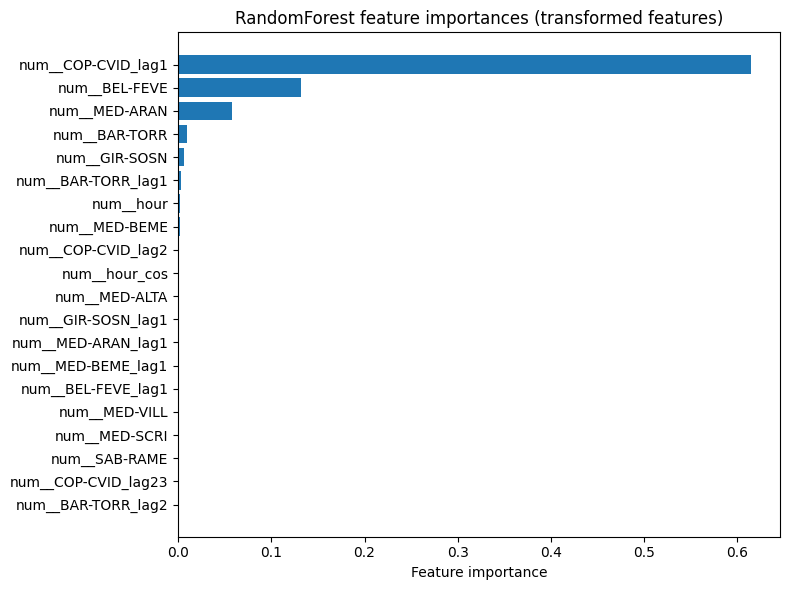

In [55]:
importances_cop_cvid = rf_cop_cvid.feature_importances_
feature_names_cop_cvid = preproc_cop_cvid.column_transformer_.get_feature_names_out()

# sort
indices_cop_cvid = np.argsort(importances_cop_cvid)[::-1]

# how many features to show
n_top = 20
top_idx_cop_cvid = indices_cop_cvid[:n_top]

plt.figure(figsize=(8, 6))
plt.barh(range(n_top), importances_cop_cvid[top_idx_cop_cvid][::-1])
plt.yticks(range(n_top), [feature_names_cop_cvid[i] for i in top_idx_cop_cvid][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest feature importances (transformed features)")
plt.tight_layout()
plt.show()

In [56]:
# Create an importances dataframe

importances_df_cop_cvid=pd.DataFrame(importances_cop_cvid, index=feature_names_cop_cvid, columns=['Importancia'])

In [57]:
important_features_cop_cvid=importances_df_cop_cvid.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

In [58]:
importances_df_cop_cvid.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

['num__COP-CVID_lag1',
 'num__BEL-FEVE',
 'num__MED-ARAN',
 'num__BAR-TORR',
 'num__GIR-SOSN',
 'num__BAR-TORR_lag1',
 'num__hour',
 'num__MED-BEME',
 'num__COP-CVID_lag2',
 'num__hour_cos',
 'num__MED-ALTA',
 'num__GIR-SOSN_lag1',
 'num__MED-ARAN_lag1',
 'num__MED-BEME_lag1',
 'num__BEL-FEVE_lag1',
 'num__MED-VILL',
 'num__MED-SCRI',
 'num__SAB-RAME',
 'num__COP-CVID_lag23',
 'num__BAR-TORR_lag2']

In [59]:
important_features_list_cop_cvid = [feat.split('__')[-1] for feat in important_features_cop_cvid]

In [60]:
important_features_list_cop_cvid

['COP-CVID_lag1',
 'BEL-FEVE',
 'MED-ARAN',
 'BAR-TORR',
 'GIR-SOSN',
 'BAR-TORR_lag1',
 'hour',
 'MED-BEME',
 'COP-CVID_lag2',
 'hour_cos',
 'MED-ALTA',
 'GIR-SOSN_lag1',
 'MED-ARAN_lag1',
 'MED-BEME_lag1',
 'BEL-FEVE_lag1',
 'MED-VILL',
 'MED-SCRI',
 'SAB-RAME',
 'COP-CVID_lag23',
 'BAR-TORR_lag2']

In [61]:
X_train_small_cop_cvid = X_train_cop_cvid[:, top_idx_cop_cvid[:15]]
X_test_small_cop_cvid  = X_test_cop_cvid[:,  top_idx_cop_cvid[:15]]
X_val_small_cop_cvid   = X_val_cop_cvid[:,   top_idx_cop_cvid[:15]]

In [62]:
rf_small_cop_cvid = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_small_cop_cvid.fit(X_train_small_cop_cvid, y_train_cop_cvid)

y_test_pred_cop_cvid = rf_small_cop_cvid.predict(X_test_small_cop_cvid)
y_val_pred_cop_cvid  = rf_small_cop_cvid.predict(X_val_small_cop_cvid)

print("Test R2 (small model):", r2_score(y_test_cop_cvid, y_test_pred_cop_cvid))
print("Val  R2 (small model):", r2_score(y_val_cop_cvid,  y_val_pred_cop_cvid))
print("Test RMSE (small model):",
      root_mean_squared_error(y_test_cop_cvid, y_test_pred_cop_cvid))
print("Val  RMSE (small model):",
      root_mean_squared_error(y_val_cop_cvid,  y_val_pred_cop_cvid))

Test R2 (small model): 0.6762065700451655
Val  R2 (small model): 0.7926445954372917
Test RMSE (small model): 4.36297708442229
Val  RMSE (small model): 4.178656689767312
